# Continuous Control with DDPG


### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!
Run this only in the Udacity environment.

In [1]:
!pip -q install ./python # only needed in Udacity cloud environment.

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.


Relevant libraries are imported.

In [2]:
from unityagents import UnityEnvironment

import pickle
import os
import gym
import numpy as np

import random
import time  
import copy
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
%matplotlib inline

Activate the environment.

In [3]:
# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to explore the environment a bit.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]

print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents) # initialize the score (for each agent)

n = 0
while True:
    n += 1
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
        
print(n)
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

1001
Total score (averaged over agents) this episode: 0.10449999766424298


The Actor and Critic networks are defined. The agent instantiates a local and target instance of both. 

In [9]:
# hyperparameters as in paper:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 512     # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 2e-4         # learning rate of the actor 
LR_CRITIC = 2e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
UPDATE_EVERY = 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise((num_agents, action_size), random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        
        # define time step, after UPDATE_EVERY steps, the model weights are updated.
        self.time_st = 0
       
    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            self.memory.add(state, action, reward, next_state, done) 

        # Learn, if enough samples are available in memory
        self.time_st = (self.time_st + 1) % UPDATE_EVERY
        if self.time_st == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
          
    def act(self, state, add_noise=True):
        """
        Returns actions for given state as per current policy.
        
        """

        state = torch.from_numpy(state).float().to(device)

        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()

        if add_noise:
            action += self.noise.sample()
           
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU) 
    

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [7]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc_units=128, fc_units2=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, fc_units2)
        self.fc3 = nn.Linear(fc_units2, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        
        
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=64, fc2_units=64, fc3_units=32):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

The noise class is defined. Noise is added to the action of all agents.

In [8]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

In [10]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

Let's start! 

In [11]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)

# size of each action
action_size = brain.vector_action_space_size

# size of the states
states = env_info.vector_observations
state_size = states.shape[1]

print(state_size)

# create an instance of the agent
agent = Agent(state_size=state_size, action_size=action_size, random_seed=12)

33


In [12]:
def ddpg(n_episodes=200):
    
    scores = []
    scores_window = deque(maxlen=100)
    
    best_score = 0
    best_av_score = 0
    
    # play max 200 episodes
    for i_episode in range(1, n_episodes+1):
        
        # initialize environment and get states
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations            
        scores_agents = np.zeros(num_agents)             
        agent.reset()
        
        # initialize scores
        score = 0
        av_score = 0 # this should become higher than 30
        
        # repeat sequence of action, reward and next_states, until any of the 20 agents is done
        while True:
            
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]  
            rewards = env_info.rewards
            next_states = env_info.vector_observations                    
            dones = env_info.local_done 
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            scores_agents += rewards
            if np.any(dones):
                break
                
        score = np.mean(scores_agents)
        scores_window.append(score)
        av_score = np.mean(scores_window)
        scores.append(score)
        
        if score > best_score:
            best_score = score
        if av_score > best_av_score:
            best_av_score = av_score
            
        print("Episode:{}, Low Score:{:.2f}, High Score:{:.2f}, Score:{:.2f}, Best Score:{:.2f}, Average Score:{:.2f}, Best Avg Score:{:.2f}".format(i_episode, scores_agents.min(), scores_agents.max(), score, best_score, av_score, best_av_score))
        
        if av_score > 30 and len(scores_window) > 99:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print("Average score of 30 achieved")            
            break
            
    return scores, scores_window

scores, scores_window = ddpg()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:107: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Episode:1, Low Score:0.16, High Score:1.43, Score:0.82, Best Score:0.82, Average Score:0.82, Best Avg Score:0.82
Episode:2, Low Score:0.07, High Score:2.29, Score:0.94, Best Score:0.94, Average Score:0.88, Best Avg Score:0.88
Episode:3, Low Score:0.00, High Score:2.85, Score:1.32, Best Score:1.32, Average Score:1.03, Best Avg Score:1.03
Episode:4, Low Score:0.33, High Score:2.64, Score:1.27, Best Score:1.32, Average Score:1.09, Best Avg Score:1.09
Episode:5, Low Score:0.37, High Score:2.81, Score:1.28, Best Score:1.32, Average Score:1.13, Best Avg Score:1.13
Episode:6, Low Score:0.60, High Score:3.00, Score:1.34, Best Score:1.34, Average Score:1.16, Best Avg Score:1.16
Episode:7, Low Score:0.54, High Score:3.14, Score:1.55, Best Score:1.55, Average Score:1.22, Best Avg Score:1.22
Episode:8, Low Score:0.52, High Score:2.84, Score:1.44, Best Score:1.55, Average Score:1.24, Best Avg Score:1.24
Episode:9, Low Score:0.00, High Score:2.23, Score:1.04, Best Score:1.55, Average Score:1.22, Bes

Episode:73, Low Score:16.57, High Score:31.48, Score:25.28, Best Score:25.28, Average Score:9.17, Best Avg Score:9.17
Episode:74, Low Score:18.98, High Score:34.60, Score:26.87, Best Score:26.87, Average Score:9.41, Best Avg Score:9.41
Episode:75, Low Score:17.68, High Score:33.59, Score:27.32, Best Score:27.32, Average Score:9.65, Best Avg Score:9.65
Episode:76, Low Score:22.56, High Score:33.80, Score:29.19, Best Score:29.19, Average Score:9.91, Best Avg Score:9.91
Episode:77, Low Score:22.51, High Score:35.21, Score:29.09, Best Score:29.19, Average Score:10.16, Best Avg Score:10.16
Episode:78, Low Score:21.38, High Score:37.53, Score:30.57, Best Score:30.57, Average Score:10.42, Best Avg Score:10.42
Episode:79, Low Score:22.78, High Score:34.78, Score:30.07, Best Score:30.57, Average Score:10.67, Best Avg Score:10.67
Episode:80, Low Score:24.09, High Score:33.81, Score:30.65, Best Score:30.65, Average Score:10.92, Best Avg Score:10.92
Episode:81, Low Score:24.15, High Score:37.77, S

Episode:141, Low Score:31.33, High Score:37.62, Score:34.62, Best Score:37.40, Average Score:28.62, Best Avg Score:28.62
Episode:142, Low Score:31.19, High Score:38.99, Score:35.59, Best Score:37.40, Average Score:28.91, Best Avg Score:28.91
Episode:143, Low Score:28.82, High Score:38.02, Score:34.01, Best Score:37.40, Average Score:29.17, Best Avg Score:29.17
Episode:144, Low Score:32.65, High Score:39.17, Score:35.78, Best Score:37.40, Average Score:29.44, Best Avg Score:29.44
Episode:145, Low Score:28.87, High Score:38.36, Score:35.08, Best Score:37.40, Average Score:29.70, Best Avg Score:29.70
Episode:146, Low Score:32.03, High Score:38.25, Score:35.19, Best Score:37.40, Average Score:29.94, Best Avg Score:29.94
Episode:147, Low Score:25.67, High Score:38.23, Score:34.95, Best Score:37.40, Average Score:30.17, Best Avg Score:30.17
Average score of 30 achieved


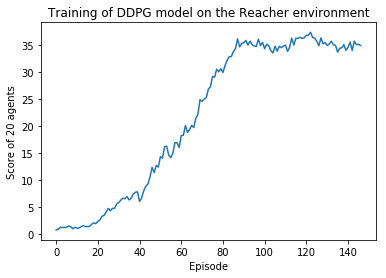

In [13]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.title('Training of DDPG model on the Reacher environment')
plt.ylabel('Score of 20 agents')
plt.xlabel('Episode')
plt.show()

In [14]:
fig.savefig('train_reacher.png')